# Exercice 4: MWC297: continuum vs line emission

Here, we illustrate the use of a chromatic interpolator in the case of high resolution MATISSE data obtained on the massive and luminous YSO MWC 297. We will focus on the gaseous Br$\alpha$ emission around 4.05$\mu$m, and its adjacent continuum (produced by the dust). 

The aim is to determine the size of those two emitting components, thus informing us about the physical process at the origin of the gas
emission.

The dataset, obtained with the medium AT array, consists of one file **OiXP MWC 297 MATISSE D0-G2-J3-K0 2022-05-31.fits** that you can download from the school archive.


### First we import the oimodeler module and other libraries

In [4]:
import oimodeler as oim
import matplotlib.pyplot as plt 

#### Then we set the path to our oifits files. 

In [5]:
from pathlib import Path
dir0 = Path("C:\\Travail\\Cours et TP\\VLTI2024\\OIDATA\\data\\oifits\\MWC297") 
filename = dir0 / 'OiXP_MWC_297_MATISSE_D0-G2-J3-K0_2022-05-31.fits'
data = oim.oimData(filename)
data.dataInfo

[[{'arr': 'OI_VIS2', 'idx': 4, 'nB': (6, 1566), 'data': ['VIS2DATA']},
  {'arr': 'OI_T3', 'idx': 5, 'nB': (4, 1566), 'data': ['T3PHI']},
  {'arr': 'OI_VIS', 'idx': 6, 'nB': (6, 1566), 'data': ['VISAMP', 'VISPHI']},
  {'arr': 'OI_FLUX', 'idx': 7, 'nB': (1, 1566), 'data': ['FLUXDATA']}]]

## Checking and plotting data

Determining a size for the continuum and line emitting components requires the spatial information from the visibilities and the flux information from the total flux. Here, we plot the squared visibilities against spatial frequency, and flux against wavelength:

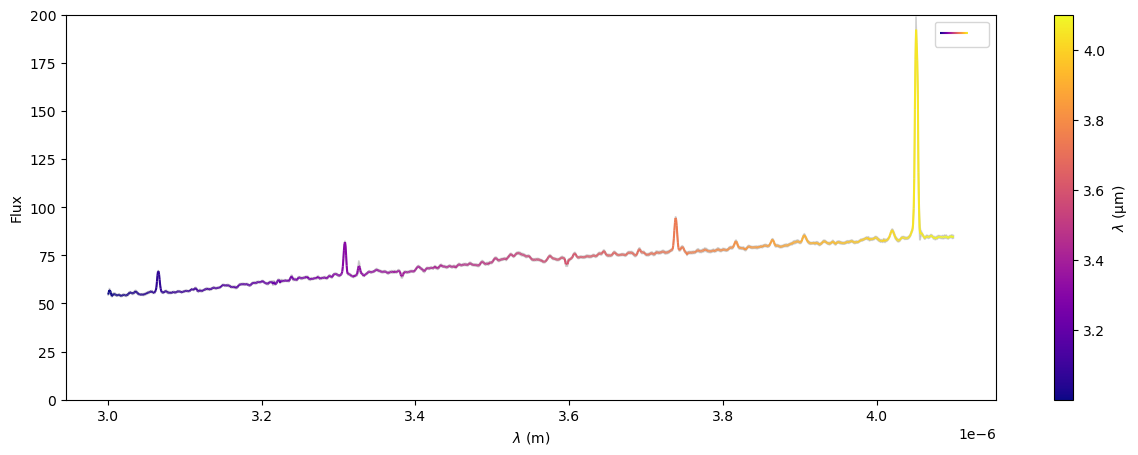

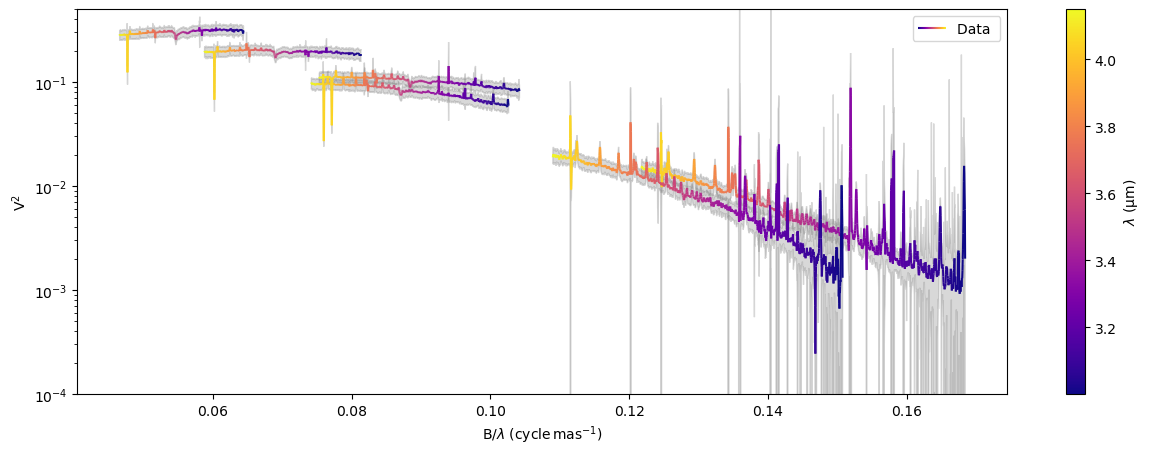

In [6]:
fig1 = plt.figure(figsize=(15,5))
ax1 = plt.subplot(projection='oimAxes')
ax1.oiplot(data,"EFF_WAVE","FLUXDATA", errorbar=True,kwargs_error={"alpha":0.3},cname="EFF_WAVE",cunit="micron")
ax1.set_ylim([0,200])
ax1.legend()

fig2 = plt.figure(figsize=(15,5))
ax2 = plt.subplot(projection='oimAxes')
ax2.oiplot(data,"SPAFREQ","VIS2DATA",xunit="cycle/mas",label="Data",cname="EFF_WAVE",cunit="micron",errorbar=True,kwargs_error={"alpha":0.3})
ax2.set_ylim([1e-4,0.5])
ax2.set_yscale("log")
ax2.legend()

#### **Question: Evaluate the flux contribution from the line emission relative to the continuum**

#### **Question:  According to the shape of the Br$\alpha$ line in the V2, is the line-emitting region larger or smaller than the L-band continuum?**

Tip: You might need to zoom on some part of the data using **set_xlim** and **set_ylim** methods.

### Wavelength filtering on a narrow region around B$\alpha$ 

**Replace --- --- in wlRange by proper values**

In [24]:
filt = oim.oimWavelengthRangeFilter(targets="all", wlRange=[4.04e-6, 4.065e-6])
data.setFilter(oim.oimDataFilter(filt))

### Plotting the flux as a function of wavelength as a check

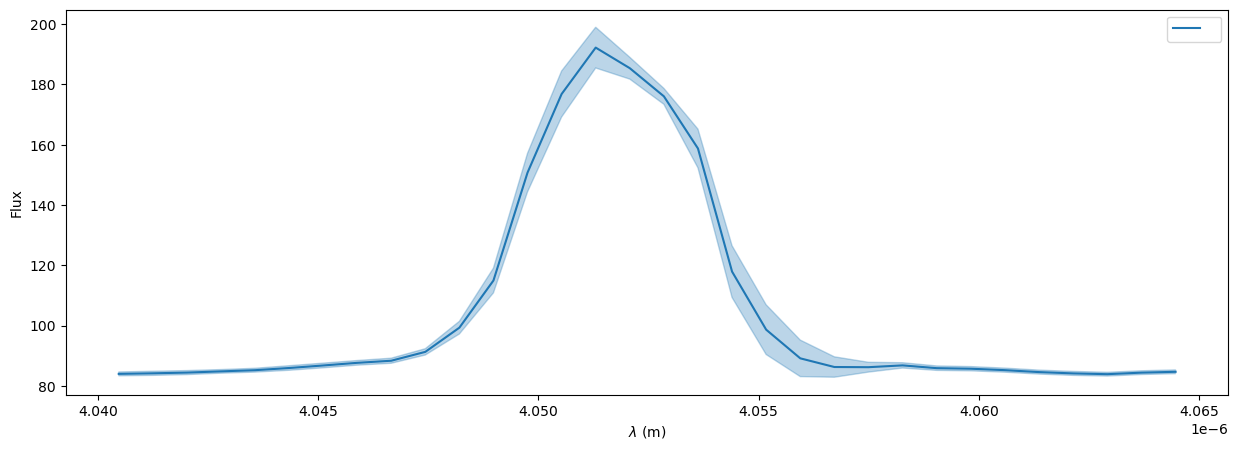

In [25]:
fig1 = plt.figure(figsize=(15,5))
ax1 = plt.subplot(projection='oimAxes')
ax1.oiplot(data,"EFF_WAVE","FLUXDATA", errorbar=True,kwargs_error={"alpha":0.3})
ax1.legend()

## Creation of MWC297 continuum + line model

In the case of YSOs, the mid-infrared continuum emission is usually due to the star plus a circumstellar dusty component.  Here, we add a component that represents the Br$\gamma$ gas line emission. For sake of simplicity, we will assume an elliptical gaussian geometry for the two circumstellar components.

Our model is thus composed of :
- a point source star 
- an elliptical Gaussian distribution for the circumstellar continuum emission 
- a second elliptical Gaussian distribution for the line emission

As the flatening of the Gaussian components is supposed to represent the projection of circumstellar disk we decide link the **pa** and **elong** parameters of both Gaussian components.

Finally we use a **gaussian wavelength interpolator** to reproduce the flux variation between the continuum and the line.


In [26]:
wl0 = 4.0518e-6 # meter

star = oim.oimPt()
continuum = oim.oimEGauss()
line = oim.oimEGauss(f=oim.oimInterp('GaussWl',val0=0, value=100, x0=wl0, fwhm=5e-9))
line.params['pa']=oim.oimParamLinker(continuum.params['pa'])
line.params['elong']=oim.oimParamLinker(continuum.params['elong'])
model = oim.oimModel(star,continuum,line)

#### **Question: Can you explain the values used in the Gaussian interpolator?**

Note, you can check **oimodeler** help [here](https://oimodeler.readthedocs.io/en/latest/advancedExamples.html#parameters-interpolators)

### Getting the comprehensive list of parameters in our model including the interpolator ones

The easiest way to access the parameters of the interpolator is to use the model **getParameters** method that returns a dictionary of all parameters (free and fixed) of all components of the model.

In our example, the parameters of Gaussian interpolator on the flux of the third component (Elliptical Gaussian for the line emission) are named : 
- **c3_EG_f_interp1** :  x0
- **c3_EG_f_interp2** :  fwhm
- **c3_EG_f_interp3** :  val0 (here a flux called f)
- **c3_EG_f_interp4** :  value (here a flux called f)
  

In [27]:
params = model.getParameters()
params

{'c1_Pt_x': oimParam at 0x1d5e8c04610 : x=0 ± 0 mas range=[-inf,inf] free=False ,
 'c1_Pt_y': oimParam at 0x1d5e8c54090 : y=0 ± 0 mas range=[-inf,inf] free=False ,
 'c1_Pt_f': oimParam at 0x1d5e8c56fd0 : f=1 ± 0  range=[0,1] free=True ,
 'c2_EG_x': oimParam at 0x1d5e8c55210 : x=0 ± 0 mas range=[-inf,inf] free=False ,
 'c2_EG_y': oimParam at 0x1d5e8c07210 : y=0 ± 0 mas range=[-inf,inf] free=False ,
 'c2_EG_f': oimParam at 0x1d5e8c58990 : f=1 ± 0  range=[0,1] free=True ,
 'c2_EG_elong': oimParam at 0x1d5e8c363d0 : elong=1 ± 0  range=[1,inf] free=True ,
 'c2_EG_pa': oimParam at 0x1d5e8c5ac50 : pa=0 ± 0 deg range=[-180,180] free=True ,
 'c2_EG_fwhm': oimParam at 0x1d5e8c5a090 : fwhm=0 ± 0 mas range=[0,inf] free=True ,
 'c3_EG_x': oimParam at 0x1d5e8c54150 : x=0 ± 0 mas range=[-inf,inf] free=False ,
 'c3_EG_y': oimParam at 0x1d5e8c53390 : y=0 ± 0 mas range=[-inf,inf] free=False ,
 'c3_EG_f_interp1': oimParam at 0x1d5e8bda910 : x0=4.0518e-06 ± 0 m range=[0,inf] free=True ,
 'c3_EG_f_interp2'

### Now we can set the parameter space

We fix all interpolator parameters but the last one representing the flux value in the line.

In [28]:

#continuum emission (star + disk)
params['c1_Pt_f'].set(min=0,max=100)
params['c2_EG_f'].set(min=0,max=100)
params['c2_EG_fwhm'].set(min=0,max=50)
params['c2_EG_elong'].set(min=1,max=5)
params['c2_EG_pa'].set(min=-90,max=90)

#line emission
params['c3_EG_f_interp1'].set(value = 4.0518e-6,free=False) #Gaussian interpolator x0
params['c3_EG_f_interp2'].set(value = 4e-9,free=False) #Gaussian interpolator fwhm
params['c3_EG_f_interp3'].set(value = 0,free=False) #Gaussian interpolator val0 
params['c3_EG_f_interp4'].set(value = 115,free=True,min=0,max=200) #Gaussian interpolator value

params['c3_EG_fwhm'].set(min=0,max=50)

### Verifing the list of free parameters and the parameters space

In [29]:
model.getFreeParameters()

{'c1_Pt_f': oimParam at 0x1d5e8c56fd0 : f=1 ± 0  range=[0,100] free=True ,
 'c2_EG_f': oimParam at 0x1d5e8c58990 : f=1 ± 0  range=[0,100] free=True ,
 'c2_EG_elong': oimParam at 0x1d5e8c363d0 : elong=1 ± 0  range=[1,5] free=True ,
 'c2_EG_pa': oimParam at 0x1d5e8c5ac50 : pa=0 ± 0 deg range=[-90,90] free=True ,
 'c2_EG_fwhm': oimParam at 0x1d5e8c5a090 : fwhm=0 ± 0 mas range=[0,50] free=True ,
 'c3_EG_f_interp4': oimParam at 0x1d5e782c5d0 : f=115 ± 0  range=[0,200] free=True ,
 'c3_EG_fwhm': oimParam at 0x1d5e8c53290 : fwhm=0 ± 0 mas range=[0,50] free=True }

### Running the mcmc-fitter

In [30]:
fit=oim.oimFitterEmcee(data,model,nwalkers=20,dataTypes=["VIS2DATA","FLUXDATA"])
fit.prepare(init="random")
fit.run(nsteps=7000,progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [01:19<00:00, 88.09it/s]


{'nsteps': 7000, 'progress': True}

### Plotting the results

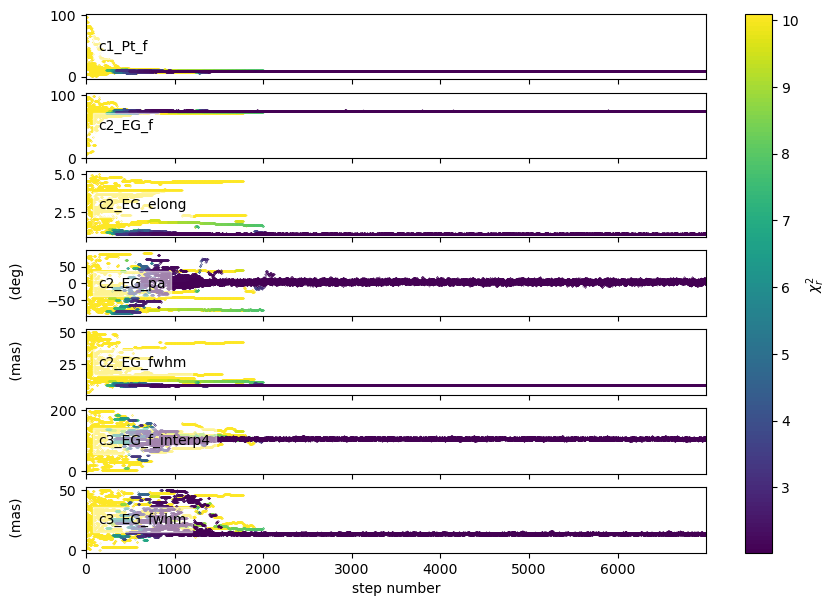

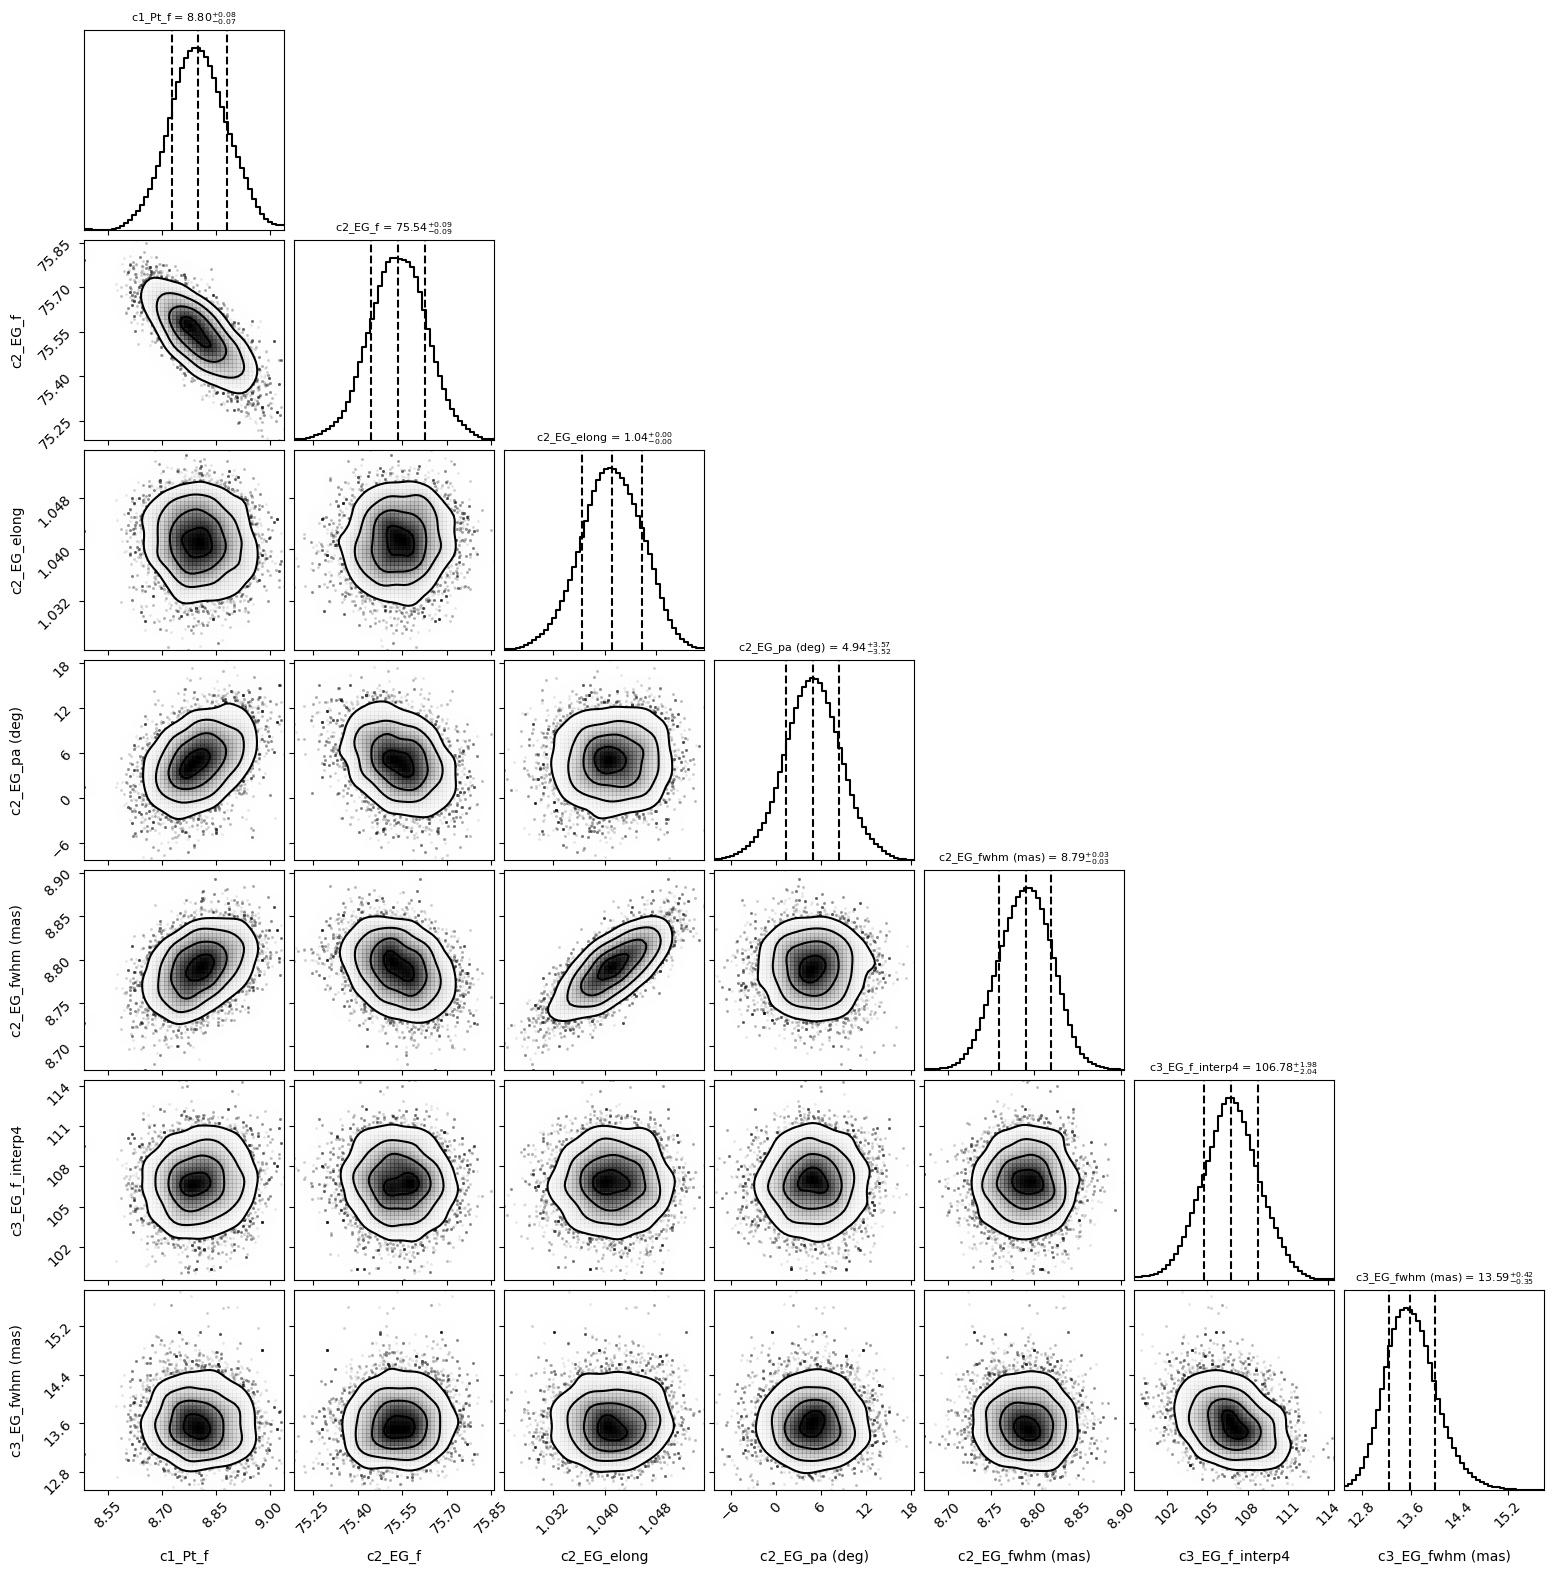

In [17]:
figWalkers,axeWalkers=fit.walkersPlot(chi2limfact=5)
figCorner,axeCorner=fit.cornerPlot(discard=6000,chi2limfact=5)

### Printing the results and best model $\chi^2_r$

In [18]:
fit.printResults(mode='median',discard=6000,chi2limfact=5)

c1_Pt_f = 8.80116 ± 0.07979 
c2_EG_f = 75.53654 ± 0.09164 
c2_EG_elong = 1.04119 ± 0.00467 
c2_EG_pa = 4.93817 ± 3.56536 deg
c2_EG_fwhm = 8.79003 ± 0.02873 mas
c3_EG_f_interp4 = 106.77897 ± 1.98315 
c3_EG_fwhm = 13.58798 ± 0.41940 mas
chi2r = 2.03467


### Wavelength-template plots to separate baselines

When studying the variation of the visibility and phase through a narrow spectral feature such as an emission line it is useful to plot data from each baseline separately.

**oimodeler** comes with this functionality using the **oimWlTemplatePlots** class which allow to create complex wavelength-plots as shown in the example below.

Here we use this to plot :
- the data in red (with errorbars) 
- the simulated data in blue


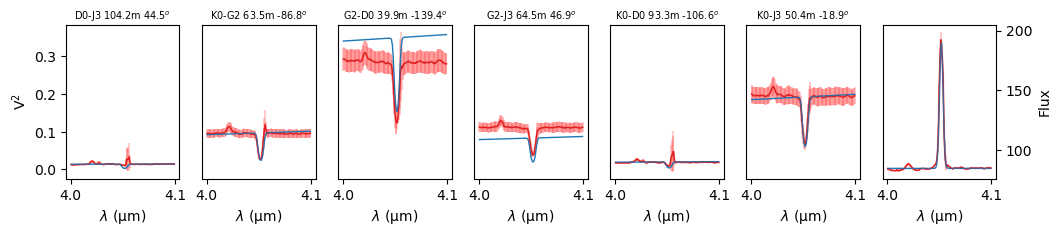

In [19]:
fig=plt.figure(FigureClass=oim.oimWlTemplatePlots, figsize=(12, 2))
fig.autoShape(data.data, shape=[["VIS2DATA","FLUXDATA"]])

fig.set_xunit("micron")

fig.plot(data, plotFunction=plt.Axes.errorbar,plotFunctionkwarg=dict(color="red", alpha=0.2))  # data errors
fig.plot(data, plotFunctionkwarg=dict(color="tab:red",lw=1)) # data
fig.plot(fit.simulator.simulatedData, plotFunctionkwarg=dict(color="tab:blue",lw=1)) # simulated data

fig.set_legends(0.5,1.03, "$BASELINE$ $LENGTH$m $PA$$^o$", "VIS2DATA",fontsize=7, ha="center")


### Plotting the image model in the Br$\gamma$ line and the surrounding continuum

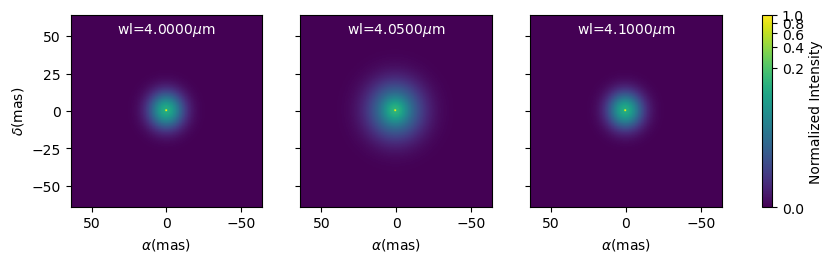

In [20]:
import numpy as np
figim, axim, im = model.showModel(128,1,wl=np.linspace(4e-6,4.1e-6,num=3),fromFT=True,normPow=0.2,legend=True,normalize=True)

### Getting the results

In [21]:
median, err,err_l ,err_u = fit.getResults(mode='median',discard=6000,chi2limfact=5)

#### **TODO: Convert the results in astronomical units**

**Put your code here**